# Backtesting

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../csv/AAPL.csv", index_col="Date")
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.410525,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.389106,43971200.0


In [4]:
#결측치 조회 (NaN, 음의 무한대, 양의 무한대)
# 이 포함된 값들만 조회하겠다. 행기준으로.
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN
1981-08-21,0.363839,0.363839,0.359375,0.359375,0.287367,NaN


In [8]:
# 결측치를 제외한 데이터 출력 (결측치가 아닌~ 애들)
# df.dropna(axis=0)는 아래와 같이도 출력 가능 (+무한대의 값도 필터링가능!)
df[df.isin([np.nan, np.inf, -np.inf]).any(1)]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN
1981-08-21,0.363839,0.363839,0.359375,0.359375,0.287367,NaN


### 종가만 가지고 테스트
  - 시간과 종가가 있는 테이터프레임

In [11]:
# df["Adj Close"]는 시리즈를 출력하게되는것이고
# 데이터프레임을 가지려면 loc!

price_df = df.loc[:, ["Adj Close"]]
price_df

,Adj Close
Date,
1980-12-12,0.410525
1980-12-15,0.389106
1980-12-16,0.360548
1980-12-17,0.369472
1980-12-18,0.380182
...,...
2019-06-18,198.449997
2019-06-19,197.869995
2019-06-20,199.460007


#### 일별 수익률 파생변수 생성 (오늘 종가 - 어제 종가) / 어제 종가
    - pct_change : diff/shift 

In [16]:
# price_df["Adj Close"].diff()/price_df["Adj Close"].shift()    이렇게 해도 되는데 이렇게 계산해주는 함수가 pct_change
price_df["daily_rtn"] = price_df["Adj Close"].pct_change()
price_df["daily_rtn"].head()

Date
1980-12-12         NaN
1980-12-15   -0.052175
1980-12-16   -0.073394
1980-12-17    0.024751
1980-12-18    0.028987
Name: daily_rtn, dtype: float64

### 일별 수익율의 누적곱 파생변수 생성

In [22]:
price_df["st_rtn"] = (1 + price_df["daily_rtn"]).cumprod()
price_df["st_rtn"]

Date
1980-12-12           NaN
1980-12-15      0.947825
1980-12-16      0.878261
1980-12-17      0.899999
1980-12-18      0.926087
                 ...    
2019-06-18    483.405388
2019-06-19    481.992558
2019-06-20    485.865677
2019-06-21    484.209242
2019-06-24    485.159242
Name: st_rtn, Length: 9715, dtype: float64

<AxesSubplot:xlabel='Date'>

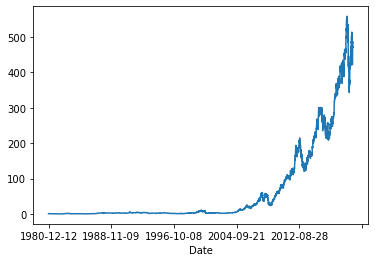

In [23]:
price_df["st_rtn"].plot()

In [19]:
first_date = price_df.index[0]
last_date = price_df.index[-1]
print(first_date, " ~ ", last_date)

1980-12-12  ~  2019-06-24


In [25]:
"""첫날부터 마지막날까지 485배 오름. 두 값이 다른이유는 첫번째방법은 첫 값이 NaN이라서"""

print(price_df.loc[last_date, 'Adj Close'] / price_df.loc[first_date, 'Adj Close'])
print(price_df.loc[last_date, 'st_rtn'])

485.15924243346933
485.1592424334637


# 2. backtesting
    - cummax() - 종가에서 최고가 저장
    - cummin() - 최대 하락 계산

In [ ]:
historical_max = price_df["Adj Close"].cummax()     #역대최고가
daily_drawdown = price_df["Adj Close"] / historical_max - 1.0       #낙폭
historical_min = price_df["Adj Close"].cummin()     #역대최저가
historical_min.plot()

    - CAGR : 일별 date 사용 -> 전체 연도를 계산하는 경우 전체 데이터의 기간을 252 영업일을 기준으로 나눈 역수를 제곱한 후 -1
    - MDD : 최대 낙폭
    - VOL : 연 주가 수익률 표준 편차 = 일별 주가 수익률 * 252일 제곱근
    - sharpe : 총 위험 1단위당 초과 수익률

In [33]:
CAGR  = price_df.loc[last_date, 'st_rtn'] ** (252/len(price_df))-1
MDD = historical_min.min()
VOL = np.std(price_df["daily_rtn"]) * np.sqrt(252)
sharpe = np.mean(price_df["daily_rtn"])/np.std(price_df["daily_rtn"])*np.sqrt(252)

In [34]:
print(VOL)
print('CAGR : ', round(CAGR*100,2), '%')
print("MDD : ", round(-1*MDD*100, 2), '%')
print("VOL : ", round(VOL*100,2), '%')
print('Sharpe : ', round(sharpe, 2))

0.4567886024251613
CAGR :  17.4 %
MDD :  -15.71 %
VOL :  45.68 %
Sharpe :  0.58


### __init__.py에 위의 정의를 class로 생성

In [75]:
import buy_and_hold as b_h
import imp
imp.reload(b_h)

<module 'buy_and_hold' from '/Users/kyle/UBION_python/220913/buy_and_hold/__init__.py'>

In [76]:
df = pd.read_csv("../csv/AMZN.csv", index_col="Date")

In [77]:
## 클래스 생성
bh_df = b_h.buyandhold(df, 'Adj Close')

In [78]:
## 결측치 제거
bh_df.drop_na()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...
2019-06-18,1901.349976,1921.670044,1899.790039,1901.369995,1901.369995,3895700
2019-06-19,1907.839966,1919.579956,1892.469971,1908.790039,1908.790039,2895300
2019-06-20,1933.329956,1935.199951,1905.800049,1918.189941,1918.189941,3217200


In [79]:
## 파생변수 생성
bh_df.add_column()

,Open,High,Low,Close,Adj Close,Volume,daily_rtn,st_rtn
Date,,,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,NaN,NaN
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.117021,0.882979
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.012049,0.872340
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.042683,0.835107
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.127389,0.728723
...,...,...,...,...,...,...,...,...
2019-06-18,1901.349976,1921.670044,1899.790039,1901.369995,1901.369995,3895700,0.008133,970.912503
2019-06-19,1907.839966,1919.579956,1892.469971,1908.790039,1908.790039,2895300,0.003902,974.701462
2019-06-20,1933.329956,1935.199951,1905.800049,1918.189941,1918.189941,3217200,0.004925,979.501413


In [81]:
result = bh_df.testing()
CAGR = result[0]
sharpe = result[1]
VOL = result[2]
MDD = result[3]

# print(VOL)
# print('CAGR : ', round(CAGR*100,2), '%')
# print("MDD : ", round(-1*MDD*100, 2), '%')
# print("VOL : ", round(VOL*100,2), '%')
# print('Sharpe : ', round(sharpe, 2))

# 3. 클래스 만들어서 try

In [ ]:
# !pip install finance-datareader
# !pip install bs4

In [53]:
import FinanceDataReader as fdr

In [54]:
ko_df = fdr.DataReader("KS11","2020-01-01","2022-09-10")
ko_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-02,2175.17,2201.21,2202.32,2171.84,494680000.0,-0.0102
2020-01-03,2176.46,2192.58,2203.38,2165.39,631560000.0,0.0006
2020-01-06,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.0098
2020-01-07,2175.54,2166.60,2181.62,2164.27,568240000.0,0.0095
2020-01-08,2151.31,2156.27,2162.32,2137.72,913830000.0,-0.0111
...,...,...,...,...,...,...
2022-09-02,2409.41,2427.70,2432.37,2402.67,391600000.0,-0.0026
2022-09-05,2403.68,2410.07,2424.77,2392.63,354740000.0,-0.0024
2022-09-06,2410.02,2409.72,2422.53,2399.26,294220000.0,0.0026


In [85]:
## 클래스 생성
bh_df_2 = b_h.buyandhold(ko_df, 'Close')

In [86]:
## 결측치 제거
bh_df_2.drop_na()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-02,2175.17,2201.21,2202.32,2171.84,494680000.0,-0.0102
2020-01-03,2176.46,2192.58,2203.38,2165.39,631560000.0,0.0006
2020-01-06,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.0098
2020-01-07,2175.54,2166.60,2181.62,2164.27,568240000.0,0.0095
2020-01-08,2151.31,2156.27,2162.32,2137.72,913830000.0,-0.0111
...,...,...,...,...,...,...
2022-09-02,2409.41,2427.70,2432.37,2402.67,391600000.0,-0.0026
2022-09-05,2403.68,2410.07,2424.77,2392.63,354740000.0,-0.0024
2022-09-06,2410.02,2409.72,2422.53,2399.26,294220000.0,0.0026


In [87]:
## 파생변수 생성
bh_df_2.add_column()

,Close,Open,High,Low,Volume,Change,daily_rtn,st_rtn
Date,,,,,,,,
2020-01-02,2175.17,2201.21,2202.32,2171.84,494680000.0,-0.0102,NaN,NaN
2020-01-03,2176.46,2192.58,2203.38,2165.39,631560000.0,0.0006,0.000593,1.000593
2020-01-06,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.0098,-0.009828,0.990759
2020-01-07,2175.54,2166.60,2181.62,2164.27,568240000.0,0.0095,0.009499,1.000170
2020-01-08,2151.31,2156.27,2162.32,2137.72,913830000.0,-0.0111,-0.011137,0.989031
...,...,...,...,...,...,...,...,...
2022-09-02,2409.41,2427.70,2432.37,2402.67,391600000.0,-0.0026,-0.002567,1.107688
2022-09-05,2403.68,2410.07,2424.77,2392.63,354740000.0,-0.0024,-0.002378,1.105054
2022-09-06,2410.02,2409.72,2422.53,2399.26,294220000.0,0.0026,0.002638,1.107969


In [88]:
result = bh_df.testing()
CAGR = result[0]
sharpe = result[1]
VOL = result[2]
MDD = result[3]

In [89]:
print(VOL)
print('CAGR : ', round(CAGR*100,2), '%')
print("MDD : ", round(-1*MDD*100, 2), '%')
print("VOL : ", round(VOL*100,2), '%')
print('Sharpe : ', round(sharpe, 2))

0.600898471235561
CAGR :  36.58 %
MDD :  94.4 %
VOL :  60.09 %
Sharpe :  0.81
